## Predicción de Cancelación de Reserva de Hotel

#### Objetivo

El objetivo del presente trabajo es desarrollar un modelo que permita predecir si un cliente cancelará o no su reservación de hotel. Se prioriza la capacidad de predicción del modelo sobre la explicabilidad.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#### Datos

El conjutno de datos fue descargado de Kaggle. Estos se encuentran bajo el nombre "Hotel Reservations Dataset" y cuenta con 36275 observaciones. Los atributos de las reservas de los clientes son los siguientes:

Booking_ID: identificador único de cada reserva.

no_of_adults: número de adultos.

no_of_children: número de niños.

no_of_weekend_nights: número de noches de fin de semana (sábado o domingo) que el huésped se quedó o reservó para quedarse en el hotel.

no_of_week_nights: número de noches de semana (de lunes a viernes) que el huésped se quedó o reservó para quedarse en el hotel.

type_of_meal_plan: tipo de plan de comidas reservado por el cliente.

required_car_parking_space: ¿El cliente requiere espacio de estacionamiento para automóviles? (0 - No, 1- Sí).

room_type_reserved: tipo de habitación reservada por el cliente. Los valores están codificados por INN Hotels.

lead_time: número de días entre la fecha de reserva y la fecha de llegada.

arrival_year: año de la fecha de llegada.

arrival_month: mes de la fecha de llegada.

arrival_date: día del mes de la fecha de llegada.

market_segment_type: designación del segmento de mercado.

repeated_guest: ¿El cliente es un huésped repetido? (0 - No, 1- Sí).

no_of_previous_cancellations: número de reservas anteriores canceladas por el cliente antes de la reserva actual.

no_of_previous_bookings_not_canceled: número de reservas anteriores no canceladas por el cliente antes de la reserva actual.

avg_price_per_room: precio promedio por día de la reserva; los precios de las habitaciones son dinámicos (en euros).

no_of_special_requests: número total de solicitudes especiales realizadas por el cliente (por ejemplo, piso alto, vista desde la habitación, etc.).

booking_status: indicador de si la reserva fue cancelada o no.

Para mayor información consultar con el diccionario de datos en la carpeta referencias.

#### Exploración Inicial de Datos

En este apartado, se realizará una exploración inicial de los datos. Esto para tener una idea de la naturaleza de los mismos, previo a la construcción del modelo.

In [3]:
data_path = os.path.join(os.getcwd(), '../data/HOtel Reservations.csv')
df = pd.read_csv(data_path)

In [4]:
# Nombres de columnas y datatypes
df.dtypes.to_frame().T

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,object,int64,int64,int64,int64,object,int64,object,int64,int64,int64,int64,object,int64,int64,int64,float64,int64,object


In [5]:
# Viendo un subconjunto de los datos
df.head(3)

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled


Primero, es necesario lidiar con datos faltantes.

In [6]:
# Revisando datos faltantes
df.isnull().sum().to_frame().T

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


La variable objetivo es "booking_status". Es importante examinar la correlación de esta varible con las demás.

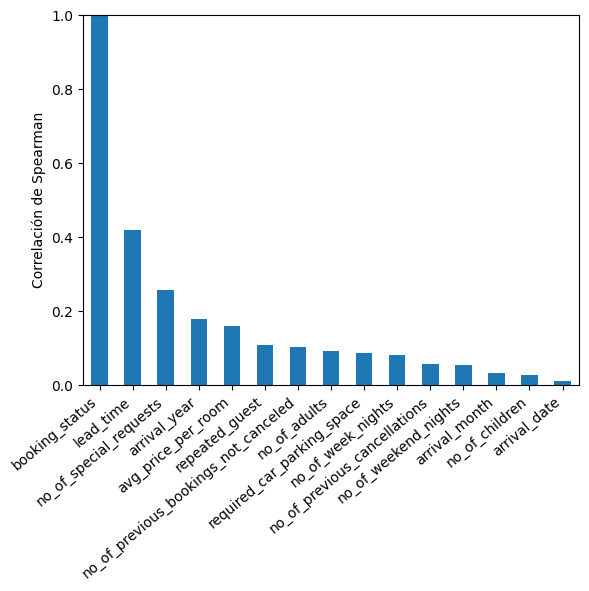

In [41]:
# Cambiando el código de la variable objetivo
df.booking_status.replace('Not_Canceled',0, inplace=True)
df.booking_status.replace('Canceled',1, inplace=True)

# Visualizando objetivos
correlations = df.corr(numeric_only=True,method='spearman').booking_status
correlations = correlations.abs().sort_values(ascending=False)
ax = correlations.plot(kind='bar')
ax.set(ylim=[0, 1], ylabel='Correlación de Spearman')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

Las primeras 5 variables son las más correlacionadas con la variable objetivo. Por lo que se procederá a hacer una exploración visual más detallada de las mismas.

In [8]:
features = correlations.index[:6]
df_features = df[features]
df_features['arrival_month'] = df['arrival_month']
df_features.head(2)

,booking_status,lead_time,no_of_special_requests,arrival_year,avg_price_per_room,repeated_guest,arrival_month
0,0,224,0,2017,65.00,0,10
1,0,5,1,2018,106.68,0,11


Se examinan las correlaciones entre las variables escogidas, incluyendo la variable objetivo.

<AxesSubplot: >

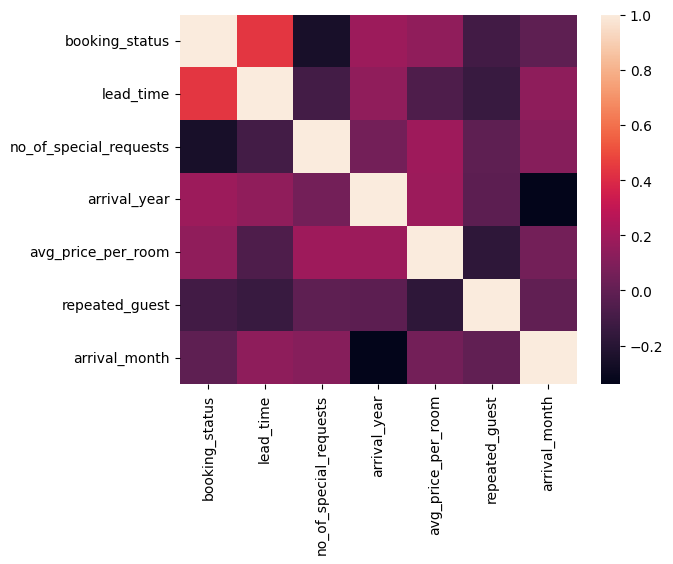

In [9]:
sns.heatmap(df_features.corr())

Ahora, se examinan los gráficos de cajas respecto a la variable objetivo. Esto para poder visulizar la relación entre ellas.

<AxesSubplot: xlabel='booking_status', ylabel='lead_time'>

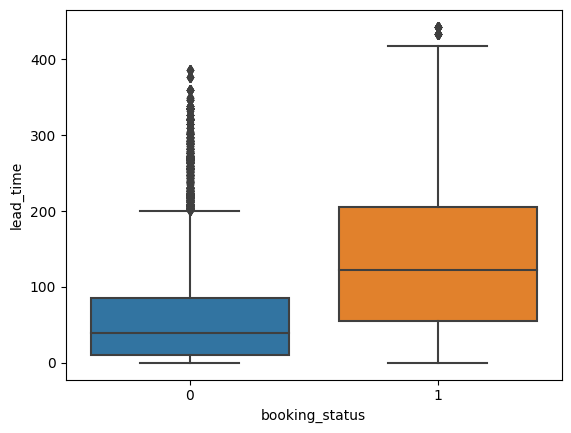

In [10]:
sns.boxplot(x=df_features.booking_status, y=df.lead_time)

<AxesSubplot: xlabel='booking_status', ylabel='avg_price_per_room'>

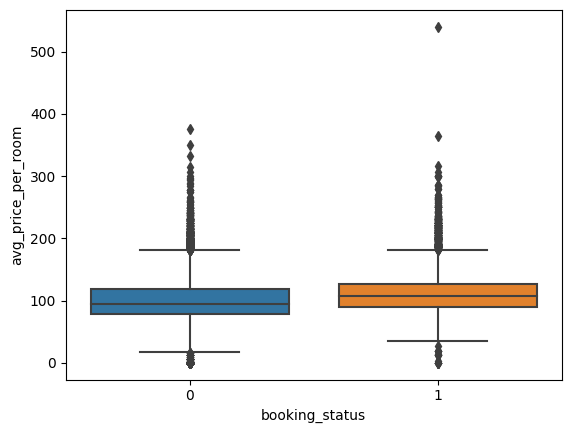

In [11]:
sns.boxplot(x=df_features.booking_status, y=df.avg_price_per_room)

<AxesSubplot: xlabel='booking_status', ylabel='lead_time'>

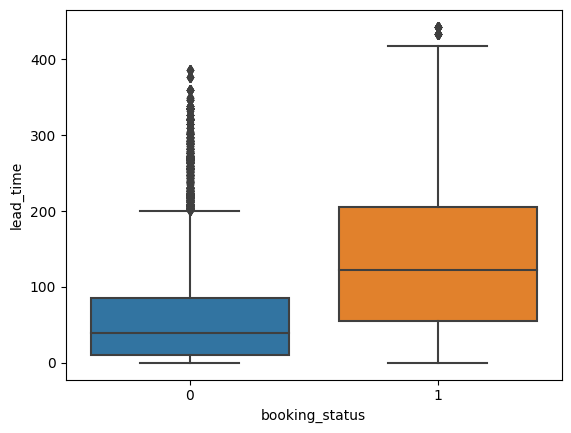

In [12]:
sns.boxplot(x=df_features.booking_status, y=df.lead_time)

De los anteriores gráficos, se puede ver que las variables escogidas sí guardan una relación con la variable objetivo. Por lo que se tomarán estas como las variables predictoras en la construcción del modelo. Adicionalmente, se tomará el mes de llegada como una sexta variable debido a la naturaleza estacionaria de las reservas de hotel.

<AxesSubplot: ylabel='booking_status'>

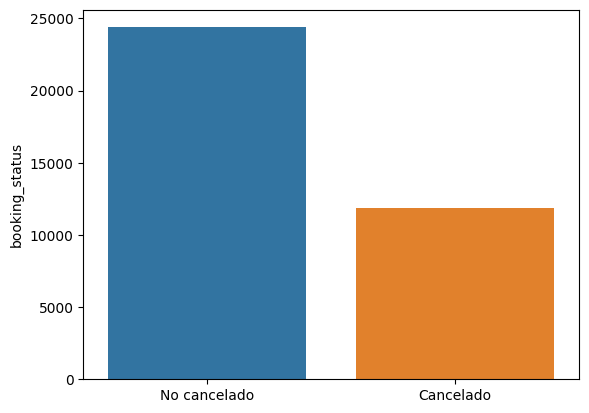

In [13]:
sns.barplot(x=["No cancelado","Cancelado"], y=df.booking_status.value_counts())

#### Construcción de los Modelos de Clasificación

En este caso, se construirán cuatro modelos diferentes: Logistic Regression, K-Nearest Neighbor, Extra Tree Classifier, Gradient Boosing. Se plantea entrenar algoritmos de diferente naturaleza para encontrar el que de mejores resultados.

Antes de construir los modelos, es necesario preprocesar los datos. 

In [14]:
#start building a model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

df_features.dtypes.to_frame().T

,booking_status,lead_time,no_of_special_requests,arrival_year,avg_price_per_room,repeated_guest,arrival_month
0,int64,int64,int64,int64,float64,int64,int64


Se removerá "arrival_year", dado que solo se tienen datos de dos años.

In [15]:
# Separando la variable objetivo
# removiendo "arrival_year" como predictor
y = df_features.booking_status
X = df_features.drop(['booking_status','arrival_year'], axis=1)

In [16]:
# Preprocesando los datos
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Separando en training set y test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Preprocesando las variables independientes
numeric_cols = ['lead_time', 'no_of_special_requests', 'avg_price_per_room',
       'repeated_guest']
cat_cols = ['arrival_month']

numeric_transformer = Pipeline([('inputer', SimpleImputer(strategy='mean')),
                               ('scaler', StandardScaler())
                               ])
cat_transformer = Pipeline([('inputer', SimpleImputer(strategy='most_frequent')),
                             ('onehot', OneHotEncoder())
                            ])

preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_cols),
                                ('cat', cat_transformer, cat_cols),
                                ])

scaler = preprocessor.fit(X_train)

X_train_scl = scaler.transform(X_train)
X_test_scl = scaler.transform(X_test)

In [17]:
# Inspección visual de las transformaciones
df_transf = pd.DataFrame(X_train_scl)

# Dando nombre a las columnas
def get_column_names(column_transformer):
  features_names =[]
  for key, value in column_transformer.named_transformers_.items():
    if hasattr(value, 'get_feature_names_out'):
      features = list(value.get_feature_names_out())
      features_names.extend(features)
  return features_names

# Inspeccionando las nuevas columnas
df_transf.columns = get_column_names(preprocessor)
df_transf.head(3)

,lead_time,no_of_special_requests,avg_price_per_room,repeated_guest,arrival_month_1,arrival_month_2,arrival_month_3,arrival_month_4,arrival_month_5,arrival_month_6,arrival_month_7,arrival_month_8,arrival_month_9,arrival_month_10,arrival_month_11,arrival_month_12
0,-0.643221,-0.785812,1.045594,-0.161057,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.853376,0.484373,1.730934,-0.161057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.722786,0.484373,0.311708,-0.161057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [18]:
# Lista para guardar las métricas
training_scores = []
test_scores = []

##### Logistic Regression

El primero model a construir es "Logistic Regression". Se usa "Grid Search" con "Cross Validation" para encontrar los mejores hiperparámetros.

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


parameters = {'C': [0.1, 1, 10],
    'penalty' : ['l1', 'l2', 'elasticnet'], 
              'solver': ['lbfgs', 'liblinear', 'sag', 'saga']}
              
lr = LogisticRegression()
grid = GridSearchCV(estimator=lr, param_grid = parameters, scoring="f1")
grid.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'sag', 'saga']},
             scoring='f1')

In [20]:
# Mostrando los mejores hiperparámetros
print('Best parameters : ', grid.best_params_)
print('train_score : ', grid.score(X_train, y_train))
print('test_score : ', grid.score(X_test, y_test))

Best parameters :  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
train_score :  0.6057111095671508
test_score :  0.6017929910350448


In [21]:
# Guardando los resultados
training_score_lg = grid.score(X_train, y_train)
test_score_lg = grid.score(X_test, y_test)
training_scores.append(training_score_lg )
test_scores.append(test_score_lg)

##### K-Nearest Neighbor

Este es el segundo algoritmo que se entrenará. A diferencia del anterior, este no es paramétrico, sino  que guarda en su memoria todos los datos para luego usarlos al realizar la predicción.

In [22]:
from sklearn.neighbors import KNeighborsClassifier

params = {'n_neighbors' : [3,4,5,6,]}
kneigh = KNeighborsClassifier()
grid = GridSearchCV(estimator=kneigh, param_grid=params, scoring="f1")
grid.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 4, 5, 6]}, scoring='f1')

In [23]:
#Scores:
print('Best parameters : ', grid.best_params_)
print('train_score : ', grid.score(X_train, y_train))
print('test_score : ', grid.score(X_test, y_test))


Best parameters :  {'n_neighbors': 3}
train_score :  0.8396613967384539
test_score :  0.7111304853240338


In [24]:
# Guardando los resultados
training_score_knn = grid.score(X_train, y_train)
test_score_knn = grid.score(X_test, y_test)
training_scores.append(training_score_knn )
test_scores.append(test_score_knn)

##### Extra Trees Classifier

Este es una mejora respecto al algoritmo "Random Forest" en el cual se añade todavia más aleatoriedad al modelo. Como consecuencia, es más robusto contra overfitting.

In [25]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV

clf = ExtraTreesClassifier()
params = {'n_estimators' : [25,50,75,100,125], 'max_depth' : [3,4,None]}
grid = GridSearchCV(estimator = clf, param_grid = params, scoring="f1")
grid.fit(X_train, y_train)

GridSearchCV(estimator=ExtraTreesClassifier(),
             param_grid={'max_depth': [3, 4, None],
                         'n_estimators': [25, 50, 75, 100, 125]},
             scoring='f1')

In [26]:
#Scores:
print('Best parameters : ', grid.best_params_)
print('train_score : ', grid.score(X_train, y_train))
print('test_score : ', grid.score(X_test, y_test))

Best parameters :  {'max_depth': None, 'n_estimators': 50}
train_score :  0.9791463414634146
test_score :  0.7925067925067925


In [27]:
# Guardando los resultados
training_score_rt = grid.score(X_train, y_train)
test_score_rt = grid.score(X_test, y_test)
training_scores.append(training_score_rt )
test_scores.append(test_score_rt)

##### Gradient Boosting

Este modelo, al igual que el "Extra Tree Classifier", es un algoritmo "Ensemble". Esto quiere decir que esta constituido por varios modelos simples, que en conjunto forman un modelo robusto. 

In [ ]:
# bypassing the bottleneck
#clf = GradientBoostingClassifier(learning_rate=1, n_estimators=600)
#clf.fit(X_train, y_train)
#training_score_gb = clf.score(X_train, y_train)
#test_score_gb = clf.score(X_test, y_test)

In [28]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()
param = {'learning_rate' : [0.1, 1], 'n_estimators' : [500, 600, 700]}
grid = GridSearchCV(estimator=clf, param_grid=param, scoring="f1")
grid.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 1],
                         'n_estimators': [500, 600, 700]},
             scoring='f1')

In [29]:
print('Best parameters : ', grid.best_params_)
print('train_score : ', grid.score(X_train, y_train))
print('test_score : ', grid.score(X_test, y_test))

Best parameters :  {'learning_rate': 1, 'n_estimators': 700}
train_score :  0.8933168316831683
test_score :  0.785334291876348


In [30]:
# Guardando los resultados
training_score_gb = grid.score(X_train, y_train)
test_score_gb = grid.score(X_test, y_test)
training_scores.append(training_score_gb )
test_scores.append(test_score_gb)

#### Evaluación

Una vez escogido los mejores modelos para cada algortimo, esto mediante el uso de Grid Seach, se procede a compararlos. Se utiliza la métrica "f1" para hacer la comparación. Esta métrica se usa debido a que se tiene un ligero desbalance en la variable objetivo.

In [31]:
test_score_gb

0.785334291876348

In [32]:
data = {'Algorithm': ['Logistic_Regression', 'KNN', 'ExtraTreesClassifier', 'Gradient_Boosting'],
        'Train_score': [training_score_lg, training_score_knn, training_score_rt, training_score_gb],
        'Test_score': [test_score_lg, test_score_knn, test_score_rt, test_score_gb]}
df_scores = pd.DataFrame(data)
df_scores

,Algorithm,Train_score,Test_score
0,Logistic_Regression,0.605711,0.601793
1,KNN,0.839661,0.711130
2,ExtraTreesClassifier,0.979146,0.792507
3,Gradient_Boosting,0.893317,0.785334


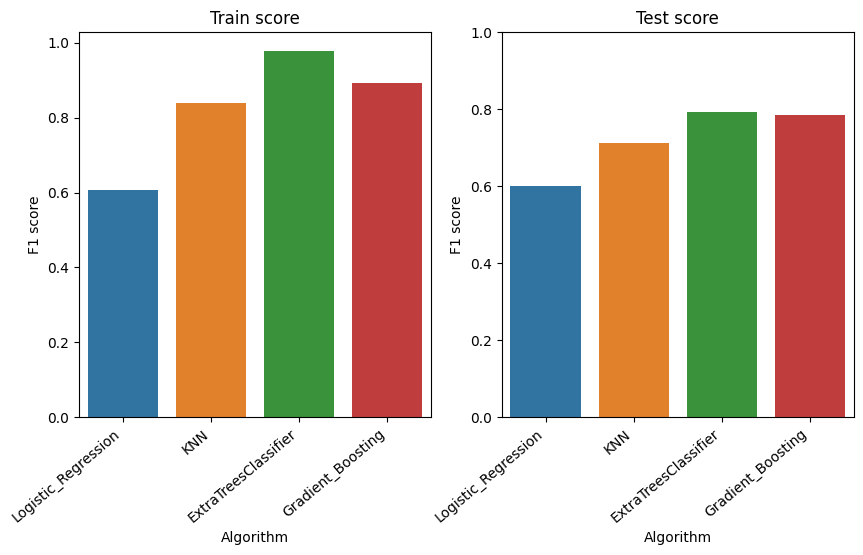

In [37]:
# create two plots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
sns.barplot(x='Algorithm', y='Train_score', ax=ax1, data=df_scores)
sns.barplot(x='Algorithm', y='Test_score', ax=ax2, data=df_scores)
plt.ylim(0, 1) 

# set titles for plots
ax1.set_title("Train score")
ax2.set_title("Test score")

ax1.set_ylabel('F1 score')
ax2.set_ylabel('F1 score')

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha="right")

# display the plots
plt.show()

Del gráfico anterior, el modelo que mejor se desempeña es "Gradient Boosting", este será el modelo seleccionado. Se puede observar que "Extra Trees Classifier" se encuentra muy cerca en cuanto a desempeño, sin embargo, este muestra señales de "overfitting".

In [38]:
#gradient boosing seems to be the best performing model

clf = GradientBoostingClassifier(learning_rate=1, n_estimators=600)

clf.fit(X_train, y_train)

print('train_score : ', clf.score(X_train, y_train))
print('test_score : ', clf.score(X_test, y_test))

train_score :  0.9277725267800883
test_score :  0.8616190388679592


In [39]:
y_test_predict = clf.predict(X_test)
df_results = X_test.copy()
df_results['y_test'] = y_test
df_results['y_test_predict'] = y_test_predict
#print(df_results)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_predict))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90      7306
           1       0.81      0.76      0.78      3577

    accuracy                           0.86     10883
   macro avg       0.85      0.84      0.84     10883
weighted avg       0.86      0.86      0.86     10883

[[6668  638]
 [ 868 2709]]


De los resultados, se puede ver que el modelo se desempeña bastante bien con ambas clases. Si bien la métrica "recall" de la clase "canceled" (que mide que tan bien clasifica los valores positivos de esta clase) esta baja relativa a la de la clase "not_canceled", su valor esta dentro de un margen aceptable.